<a href="https://colab.research.google.com/github/AmberJiayuSu/DeepLearning_FinalProject_PointPROP/blob/main/PointPROP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

 Compatible as of 2025.12
 Install dependencies (see torch installation for specific version) for RandLA Net and other dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U open3d

In [ ]:
!pip install torch==2.2.2+cu121 torchvision==0.17.2+cu121 \
  --index-url https://download.pytorch.org/whl/cu121
!pip install numpy==1.26.4

Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
from torch import nn, einsum
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm import tqdm
import random
import math
from sklearn.neighbors import KDTree
import json
from pathlib import Path
import glob
import time

In [ ]:
import open3d.ml.torch as ml3d
import open3d as o3d
import open3d.ml as _ml3d


# Data Loader

In [ ]:
class ShadingFileDataset(Dataset):
    """
    Dataset for shading prediction from a single .npz file.
    Each file contains multiple samples stored as object arrays.
    """

    def __init__(self, path, training=True):
        """
        Args:
            path: Path to single .npz file
            training: If True, apply random shuffling. If False, use deterministic shuffling.
        """
        arr = np.load(path, allow_pickle=True)
        self.context_list = arr["context_list"]   # np.ndarray(dtype=object)
        self.test_list = arr["test_list"]
        self.solar_list = arr["solar_list"]
        self.label_list = arr["label_list"]
        self.training = training
        self.file_path = path  # Store for debugging

    def __len__(self):
        return len(self.context_list)

    def __getitem__(self, idx):
        ctx = self.context_list[idx].astype(np.float32)     # (N_ctx, 3)
        test = self.test_list[idx].astype(np.float32)       # (M, 3)
        solar = self.solar_list[idx].astype(np.float32)     # (3,)
        label = self.label_list[idx].astype(np.float32)     # (M,) or (M,1)

        # Ensure label is 1D
        if label.ndim > 1:
            label = label.squeeze()

        # Shuffle context points
        if self.training:
            indices = np.random.permutation(len(ctx))
            ctx = ctx[indices]
        else:
            # For inference consistency, use fixed seed per sample
            rng = np.random.RandomState(seed=idx)
            indices = rng.permutation(len(ctx))
            ctx = ctx[indices]

        return {
            "context_points": ctx,      # (N_ctx, 3) - variable size
            "test_points": test,        # (M, 3)
            "solar_vec": solar,         # (3,)
            "labels": label,            # (M,)
        }


class MultiFileDataset(Dataset):
    """
    Dataset that combines multiple .npz files.
    More efficient than ConcatDataset for many files.
    """

    def __init__(self, npz_paths, training=True):
        """
        Args:
            npz_paths: List of paths to .npz files
            training: If True, apply random shuffling. If False, use deterministic shuffling.
        """
        self.npz_paths = npz_paths if isinstance(npz_paths, list) else [npz_paths]
        self.training = training

        # Load all files and concatenate
        all_contexts = []
        all_tests = []
        all_solars = []
        all_labels = []

        for path in self.npz_paths:
            arr = np.load(path, allow_pickle=True)
            all_contexts.append(arr["context_list"])
            all_tests.append(arr["test_list"])
            all_solars.append(arr["solar_list"])
            all_labels.append(arr["label_list"])

        # Concatenate all arrays
        self.context_list = np.concatenate(all_contexts)
        self.test_list = np.concatenate(all_tests)
        self.solar_list = np.concatenate(all_solars)
        self.label_list = np.concatenate(all_labels)

        print(f"Loaded {len(self.npz_paths)} files with {len(self.context_list)} total samples")

    def __len__(self):
        return len(self.context_list)

    def __getitem__(self, idx):
        ctx = self.context_list[idx].astype(np.float32)     # (N_ctx, 3)
        test = self.test_list[idx].astype(np.float32)       # (M, 3)
        solar = self.solar_list[idx].astype(np.float32)     # (3,)
        label = self.label_list[idx].astype(np.float32)     # (M,) or (M,1)

        # Ensure label is 1D
        if label.ndim > 1:
            label = label.squeeze()

        # Shuffle context points
        if self.training:
            indices = np.random.permutation(len(ctx))
            ctx = ctx[indices]
        else:
            # For inference consistency, use fixed seed per sample
            rng = np.random.RandomState(seed=idx)
            indices = rng.permutation(len(ctx))
            ctx = ctx[indices]

        return {
            "context_points": ctx,      # (N_ctx, 3) - variable size
            "test_points": test,        # (M, 3)
            "solar_vec": solar,         # (3,)
            "labels": label,            # (M,)
        }


def shading_collate_fn(batch):
    """
    Custom collate function for variable-sized point clouds.

    Args:
        batch: List of dicts from __getitem__

    Returns:
        Dictionary with batched tensors, keeping context_points as a list
    """
    # Context points have variable sizes - keep as list
    context_points_list = [item["context_points"] for item in batch]
    test_points_list = [item["test_points"] for item in batch]  # CHANGED: Keep as list
    labels_list = [item["labels"] for item in batch]

    # Find max test points in this batch for mask/label padding
    max_test_points = max(tp.shape[0] for tp in test_points_list)
    batch_size = len(batch)

    # ========== CHANGED: Only pad labels and create mask (no test_points padding) ==========
    labels_padded = torch.zeros((batch_size, max_test_points), dtype=torch.float32)
    test_mask = torch.zeros((batch_size, max_test_points), dtype=torch.bool)

    for i, (tp, lbl) in enumerate(zip(test_points_list, labels_list)):
        n_points = tp.shape[0]

        # Handle label shape
        lbl_tensor = torch.tensor(lbl, dtype=torch.float32)
        if lbl_tensor.dim() > 1:
            lbl_tensor = lbl_tensor.squeeze()
        labels_padded[i, :n_points] = lbl_tensor

        # Mask: True for real points, False for padding
        test_mask[i, :n_points] = True

    solar_vecs = torch.stack([
        torch.tensor(item["solar_vec"], dtype=torch.float32)
        for item in batch
    ])

    # ========== CHANGED: Return test_points as list of numpy arrays ==========
    return {
        "context_points": context_points_list,  # List of (N_i, 3) numpy arrays
        "test_points": test_points_list,        # List of (M_i, 3) numpy arrays - CHANGED
        "test_mask": test_mask,                 # (B, M_max) - True for real points
        "solar_vec": solar_vecs,                # (B, 3)
        "labels": labels_padded,                # (B, M_max) - padded
    }


def create_dataloader(npz_paths, batch_size=8, training=True, num_workers=0,
                     shuffle=None, use_concat=False):
    """
    Create a DataLoader for the shading dataset.

    Args:
        npz_paths: Single path (str) or list of paths to .npz files
        batch_size: Number of samples per batch
        training: Whether this is for training (affects shuffling in dataset)
        num_workers: Number of worker processes
        shuffle: Whether to shuffle the dataset. If None, defaults to training value.
        use_concat: If True and multiple files, use ConcatDataset (lazy loading).
                   If False, use MultiFileDataset (loads all at once, faster iteration).

    Returns:
        DataLoader instance
    """
    # Handle single path or list of paths
    if isinstance(npz_paths, str):
        npz_paths = [npz_paths]

    if shuffle is None:
        shuffle = training

    # Create dataset
    if len(npz_paths) == 1:
        # Single file - use simple dataset
        dataset = ShadingFileDataset(npz_paths[0], training=training)
    else:
        # Multiple files - choose strategy
        if use_concat:
            # ConcatDataset: Lazy loading, lower memory but slightly slower
            datasets = [ShadingFileDataset(path, training=training) for path in npz_paths]
            dataset = ConcatDataset(datasets)
        else:
            # MultiFileDataset: Loads all at once, higher memory but faster
            dataset = MultiFileDataset(npz_paths, training=training)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=shading_collate_fn,
        pin_memory=True,
    )

    return dataloader


def create_dataloader_from_pattern(pattern, batch_size=8, training=True,
                                   num_workers=4, shuffle=None, use_concat=False):
    """
    Create a DataLoader from a file pattern (e.g., 'data/chunk_*.npz').

    Args:
        pattern: Glob pattern for matching .npz files (e.g., 'data/chunk_*.npz')
        batch_size: Number of samples per batch
        training: Whether this is for training
        num_workers: Number of worker processes
        shuffle: Whether to shuffle the dataset
        use_concat: Use ConcatDataset (lazy) vs MultiFileDataset (eager)

    Returns:
        DataLoader instance
    """
    import glob

    npz_paths = sorted(glob.glob(pattern))

    if len(npz_paths) == 0:
        raise ValueError(f"No files found matching pattern: {pattern}")

    print(f"Found {len(npz_paths)} files matching pattern: {pattern}")

    return create_dataloader(
        npz_paths,
        batch_size=batch_size,
        training=training,
        num_workers=num_workers,
        shuffle=shuffle,
        use_concat=use_concat
    )


# Architecture Implementation

We have implemented three encoders, a feature encoder using RandLA, a point positional encoder, a ray encoder. (Fourier transform is optional in positional and ray encoder).

We test for MLP classification head vs transformer <br>
Also test if Fourirer encoding help.



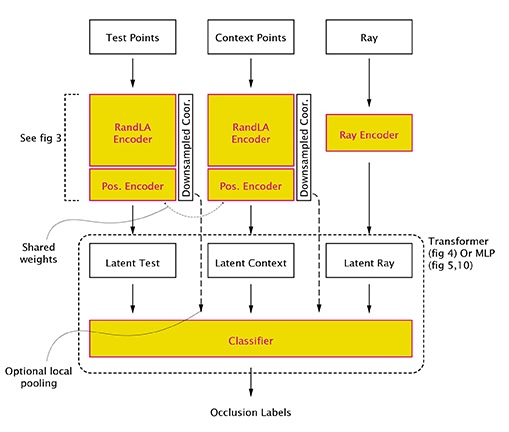

## Encoder

The point cloud encoder consists of Rand LA style encoder and a simple positional encoder

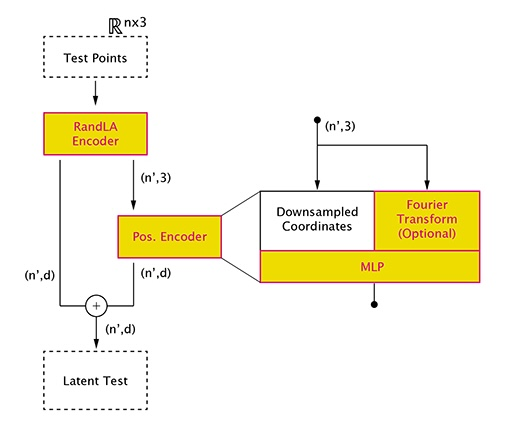

In [ ]:
class RandLAEncoder(nn.Module):
    # https://github.com/isl-org/Open3D-ML/blob/5963b94a6a424b4efbc5cf2d96134ad81d74eef1/ml3d/torch/models/randlanet.py
    # ref to code in original model
    def __init__(self, original_model,device):
        super().__init__()

        # We borrow the specific layers needed for encoding from the original model
        self.cfg = original_model.cfg
        self.cfg.num_layers = (original_model.cfg.num_layers)
        self.device = device
        self.trans_point_sampler = original_model.trans_point_sampler
        self.fc0 = original_model.fc0
        self.bn0 = original_model.bn0
        self.encoder = original_model.encoder
        #self.mlp = original_model.mlp

    def transform(self, point_clouds):
        """
        Transform a batch of point clouds.
        """
        cfg = self.cfg
        device = self.device

        # [... previous validation code ...]

        batch_size = len(point_clouds)

        # Process each point cloud independently
        batch_coords = [[] for _ in range(cfg.num_layers + 1)]
        batch_neighbors = [[] for _ in range(cfg.num_layers)]
        batch_pools = [[] for _ in range(cfg.num_layers)]
        batch_points_full = []

        # ========== ADDED: Track actual num_neighbors per sample ==========
        actual_k_per_layer = [[] for _ in range(cfg.num_layers)]

        for pc_idx, pc_full in enumerate(point_clouds):
            pc = pc_full.copy()

            for layer_i in range(cfg.num_layers):
                # Dynamically adjust num_neighbors
                actual_num_neighbors = min(cfg.num_neighbors, pc.shape[0])
                actual_k_per_layer[layer_i].append(actual_num_neighbors)  # Track it

                # KNN search for current layer
                neighbour_idx = ml3d.datasets.utils.DataProcessing.knn_search(
                    pc, pc, actual_num_neighbors
                )

                # Subsample
                n_sub = pc.shape[0] // cfg.sub_sampling_ratio[layer_i]
                sub_points = pc[:n_sub, :]
                pool_i = neighbour_idx[:n_sub, :]

                # Store for this point cloud
                batch_coords[layer_i].append(pc.copy())
                batch_neighbors[layer_i].append(neighbour_idx.astype(np.int64))
                batch_pools[layer_i].append(pool_i.astype(np.int64))

                pc = sub_points

            batch_coords[-1].append(pc.copy())
            batch_points_full.append(pc_full)

        # ========== CHANGED: Pad neighbors properly ==========
        coords_batched = []
        for layer_i in range(cfg.num_layers + 1):
            coords_batched.append(
                self._pad_and_batch(batch_coords[layer_i], dtype=torch.float32)
            )

        neighbors_batched = []
        for layer_i in range(cfg.num_layers):
            # Get the maximum K for this layer across the batch
            max_k = max(arr.shape[1] for arr in batch_neighbors[layer_i])
            neighbors_batched.append(
                self._pad_and_batch_neighbors_safe(batch_neighbors[layer_i], max_k, dtype=torch.long)
            )

        pools_batched = []
        for layer_i in range(cfg.num_layers):
            max_k = max(arr.shape[1] for arr in batch_pools[layer_i])
            pools_batched.append(
                self._pad_and_batch_neighbors_safe(batch_pools[layer_i], max_k, dtype=torch.long)
            )

        points_batched = self._pad_and_batch(batch_points_full, dtype=torch.float32)

        inputs = {
            "coords": coords_batched,
            "neighbor_indices": neighbors_batched,
            "sub_idx": pools_batched,
            "points": points_batched,
        }

        return inputs


    def _pad_and_batch_neighbors_safe(self, arrays, max_k, dtype=torch.long):
        """
        Safely pad neighbor indices by repeating the first neighbor.

        Args:
            arrays: List of numpy arrays with shape (N_i, K_i)
            max_k: Maximum K to pad to
            dtype: Target dtype

        Returns:
            Batched tensor of shape (B, max_N, max_k)
        """
        max_points = max(arr.shape[0] for arr in arrays)
        batch_size = len(arrays)

        # Initialize with zeros (will point to first point)
        batched = torch.zeros((batch_size, max_points, max_k),
                            dtype=dtype, device=self.device)

        for i, arr in enumerate(arrays):
            n_points, n_neighbors = arr.shape

            # Copy actual neighbors
            batched[i, :n_points, :n_neighbors] = torch.tensor(arr, dtype=dtype, device=self.device)

            # Pad extra neighbors: repeat the first neighbor (index 0)
            # This is safe because every point has at least itself as a neighbor
            if n_neighbors < max_k:
                first_neighbor = batched[i, :n_points, 0:1]  # (n_points, 1)
                batched[i, :n_points, n_neighbors:] = first_neighbor.repeat(1, max_k - n_neighbors)

        return batched

    def forward(self, inputs):
        """
        Forward pass with batched inputs.

        Args:
            inputs: Dictionary containing:
                - 'points': (B, N_full, 3) full resolution points
                - 'coords': List of (B, N_i, 3) coordinates at each layer
                - 'neighbor_indices': List of (B, N_i, K) neighbor indices
                - 'sub_idx': List of (B, N_{i+1}, K) pooling indices

        Returns:
            feat: (B, N_final, d) feature tensor
            final_coords: (B, N_final, 3) coordinates at final layer
        """
        cfg = self.cfg

        pts = inputs['points'].to(self.device)
        neighbor_indices_list = [
            arr.to(self.device) for arr in inputs['neighbor_indices']
        ]
        subsample_indices_list = [
            arr.to(self.device) for arr in inputs['sub_idx']
        ]
        coords_list = [arr.to(self.device) for arr in inputs['coords']]

        # Initial feature extraction
        feat = self.fc0(pts).transpose(-2, -1).unsqueeze(-1)  # (B, d, N, 1)
        feat = self.bn0(feat)

        l_relu = nn.LeakyReLU(0.2)
        feat = l_relu(feat)

        # Encoder layers
        encoder_feat_list = []
        for i in range(cfg.num_layers):
            feat_encoder_i = self.encoder[i](
                coords_list[i],
                feat,
                neighbor_indices_list[i]
            )
            feat_sampled_i = self.random_sample(
                feat_encoder_i,
                subsample_indices_list[i]
            )

            if i == 0:
                encoder_feat_list.append(feat_encoder_i.clone())
            encoder_feat_list.append(feat_sampled_i.clone())
            feat = feat_sampled_i


        # Final MLP
        #feat = self.mlp(feat)
        feat = feat.squeeze(-1).transpose(1, 2)  # (B, N_final, d)
        final_coords = coords_list[-1]  # (B, N_final, 3)

        return feat, final_coords

    def _pad_and_batch(self, arrays, dtype=torch.float32):
        """
        Pad arrays to same size and batch them.

        Args:
            arrays: List of numpy arrays with shape (N_i, ...) where N_i can vary
            dtype: Target dtype for the tensor

        Returns:
            Batched tensor of shape (B, max_N, ...)
        """
        # Find maximum size
        max_size = max(arr.shape[0] for arr in arrays)

        # Get shape of additional dimensions
        extra_dims = arrays[0].shape[1:]

        # Create padded batch tensor
        batch_size = len(arrays)
        batched = torch.zeros((batch_size, max_size, *extra_dims),
                              dtype=dtype, device=self.device)

        # Fill in the data
        for i, arr in enumerate(arrays):
            n = arr.shape[0]
            batched[i, :n] = torch.tensor(arr, dtype=dtype, device=self.device)

        return batched



    @staticmethod
    def random_sample(feature, pool_idx):
        """
        Args:
            feature: [B, d, N, 1] input features matrix
            pool_idx: [B, N', max_num] N' < N

        Returns:
            pool_features = [B, N', d] pooled features matrix
        """
        feature = feature.squeeze(3)
        num_neigh = pool_idx.size()[2]
        batch_size = feature.size()[0]
        d = feature.size()[1]

        pool_idx = torch.reshape(pool_idx, (batch_size, -1))
        pool_idx = pool_idx.unsqueeze(2).expand(batch_size, -1, d)

        feature = feature.transpose(1, 2)
        pool_features = torch.gather(feature, 1, pool_idx)
        pool_features = torch.reshape(pool_features,
                                      (batch_size, -1, num_neigh, d))
        pool_features, _ = torch.max(pool_features, 2, keepdim=True)
        pool_features = pool_features.permute(0, 3, 1, 2)

        return pool_features

In [ ]:
class FourierEmbedding(nn.Module):
    """
    NeRF-style positional encoding:
    x (B, N, in_dim) -> γ(x) (B, N, out_dim)

    For each scalar p, we create:
        [sin(2^0 π p), cos(2^0 π p), ..., sin(2^{L-1} π p), cos(2^{L-1} π p)]
    Optionally we also include the original p.
    """
    def __init__(self, in_dim: int, num_frequencies: int, include_input: bool = True):
        super().__init__()
        self.in_dim = in_dim
        self.num_frequencies = num_frequencies
        self.include_input = include_input

        # Frequencies: [1, 2, 4, ..., 2^{L-1}]
        self.register_buffer(
            "freq_bands",
            2.0 ** torch.arange(num_frequencies, dtype=torch.float32)
        )

        base_dim = in_dim * (2 * num_frequencies)
        self.out_dim = base_dim + (in_dim if include_input else 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (..., in_dim)
        returns: (..., out_dim)
        """
        # x shape: (..., in_dim)
        # Expand for broadcasting over frequencies
        # new shape: (..., in_dim, 1)
        x_expanded = x.unsqueeze(-1)  # (..., in_dim, 1)

        # freq_bands: (L,) -> (1, 1, L) for broadcast
        freqs = self.freq_bands.view(*([1] * (x.dim() - 1)), -1)  # (..., 1, L)

        # (..., in_dim, L)
        angles = math.pi * x_expanded * freqs

        sin = torch.sin(angles)
        cos = torch.cos(angles)

        # Concatenate sin and cos along last dim: (..., in_dim, 2L)
        fourier = torch.cat([sin, cos], dim=-1)

        # Flatten last two dims into feature dim: (..., in_dim * 2L)
        fourier = fourier.flatten(-2)

        if self.include_input:
            return torch.cat([x, fourier], dim=-1)
        else:
            return fourier


In [ ]:
class PtPositionEncoder(nn.Module):
  """
    Point-wise positional encoder for 3D coordinates.

    This module maps input point coordinates x ∈ R^{N×in_dim} into a learned
    embedding of dimension `output_dim`. Optionally, it applies a Fourier
    positional encoding before passing the features through a small MLP
    followed by LayerNorm.

    Args:
        device: Torch device on which to allocate internal tensors.
        in_dim (int): Input coordinate dimension (default: 3 for (x, y, z)).
        output_dim (int): Dimension of the output positional embedding.
        use_fourier (bool): If True, apply FourierEmbedding to the input
            coordinates before the MLP. If False, use raw coordinates.
        num_frequencies (int): Number of Fourier frequencies used in the
            positional encoding. Lower values yield more low-frequency bias.
        include_input (bool): If True, concatenate the original coordinates
            to the Fourier features (standard NeRF-style encoding).

    Shapes:
        Input:
            x: Tensor of shape (..., in_dim)
        Output:
            Tensor of shape (..., output_dim)

    Notes:
        - When `use_fourier=True`, the effective input to the MLP is
          `self.posenc.out_dim`, determined by FourierEmbedding.
        - The encoder is purely point-wise (no interaction between points)
          and can be used for both context and test point clouds.
    """
  def __init__(self,
        device,
        in_dim: int = 3,
        output_dim: int = 64,
        use_fourier: bool = True,
        num_frequencies: int = 4,    # lower than position
        include_input: bool = True):
    super().__init__()
    self.device=device
    self.use_fourier = use_fourier

    if use_fourier:
        self.posenc = FourierEmbedding(
            in_dim=in_dim,
            num_frequencies=num_frequencies,
            include_input=include_input,
        )
        first_layer_in_dim = self.posenc.out_dim
    else:
        self.posenc = nn.Identity()
        first_layer_in_dim = in_dim

    self.output_dim = output_dim
    self.mlp = nn.Sequential(
        nn.Linear(first_layer_in_dim, 32),
        nn.ReLU(inplace=True),
        nn.Linear(32, 64),
        nn.ReLU(inplace=True),
        nn.Linear(64, output_dim),
    )
    self.norm = nn.LayerNorm(output_dim)

  def forward(self, x):
    x_enc = self.posenc(x)
    return self.norm(self.mlp(x_enc))


In [ ]:
class Solar_Embed(nn.Module):
  """
    Solar ray direction encoder.

    This module encodes a 3D solar direction vector into a fixed-dimensional
    embedding that conditions the model on incident ray direction. Optionally,
    a low-frequency Fourier positional encoding is applied to improve the model's
    sensitivity to directional variations while avoiding excessive high-frequency
    capacity.

    Args:
        device: Torch device on which to allocate internal tensors.
        in_dim (int): Input dimensionality of the solar vector (default: 3).
        output_dim (int): Dimension of the output solar embedding.
        use_fourier (bool): If True, apply FourierEmbedding to the solar vector
            before the MLP. If False, use the raw vector.
        num_frequencies (int): Number of Fourier frequencies used for encoding
            the solar direction. Typically lower than point positional encoding.
        include_input (bool): If True, concatenate the original solar vector
            to the Fourier features.

    Shapes:
        Input:
            solar_vec: Tensor of shape (..., in_dim)
        Output:
            Tensor of shape (..., output_dim)

    Notes:
        - Compared to point positional encoding, fewer Fourier frequencies are
          used to impose a smoother, low-frequency inductive bias over direction.
        - The resulting embedding can be broadcast and fused with point-level
          features to condition occlusion or radiation predictions on sun angle.
    """
  def __init__(self,
        device,
        in_dim: int = 3,
        output_dim: int = 64,
        use_fourier: bool = True,
        num_frequencies: int = 2,
        include_input: bool = True):
    super().__init__()
    self.device = device
    self.use_fourier = use_fourier

    if use_fourier:
        self.posenc = FourierEmbedding(
            in_dim=in_dim,
            num_frequencies=num_frequencies,
            include_input=include_input,
        )
        first_layer_in_dim = self.posenc.out_dim
    else:
        self.posenc = nn.Identity()
        first_layer_in_dim = in_dim

    self.mlp = nn.Sequential(
        nn.Linear(first_layer_in_dim, 64),
        nn.ReLU(inplace=True),
        nn.Linear(64, output_dim),
    )
    self.norm = nn.LayerNorm(output_dim)


  def forward(self, solar_vec):  # (B, 3)
    x_enc = self.posenc(solar_vec)
    return self.norm(self.mlp(x_enc))

## Classification Head

Implemented 3 classification head


1.   MLP V1 with scene (context + ray) global pooling
2.   MLP V2 expanded V1 with KNN based local pooling for each test points
3.   Transformer with cross-attention (scene as KV, test as Q)



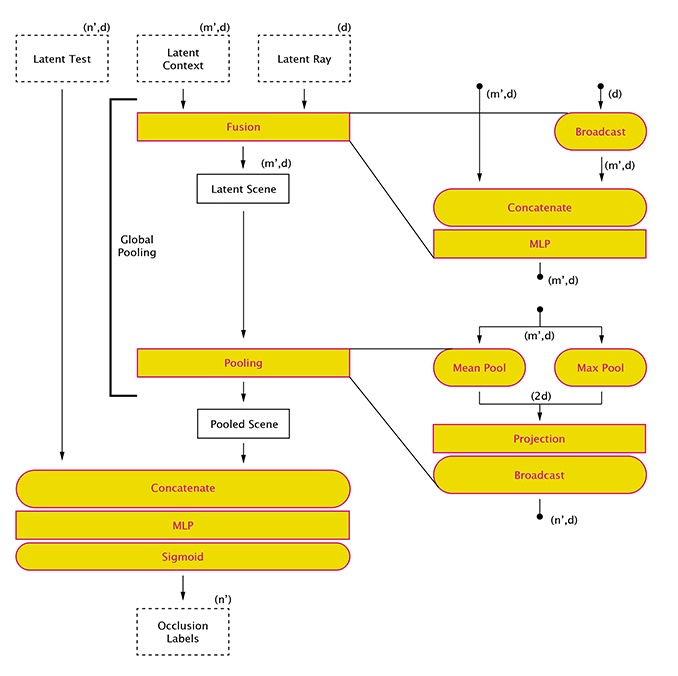

In [ ]:
class ShadingSurrogateMLP(nn.Module):
   """
    MLP-based surrogate for point-wise solar ray occlusion prediction.

    Encodes context points, test points, and solar direction, fuses solar
    information into context features, pools global context, and predicts
    per-test-point occlusion logits.

    Inputs:
        context: (B, N, 3)   Context point cloud
        test:    (B, M, 3)   Test points
        solar:   (B, 3)      Solar direction vector

    Outputs:
        dict containing:
            logits: (B, M)   Binary occlusion logits
            prob:   (B, M)   Sigmoid probabilities
    """
    def __init__(self, context_encoder, test_encoder,pos_encoder,solar_encoder, embed_dim=64,hidden_dim=32, fusion_type = 'concat'):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.fusion_type = fusion_type
        self.context_encoder = context_encoder
        self.test_encoder = test_encoder
        self.pos_encoder = pos_encoder
        self.solar_encoder = solar_encoder

        if fusion_type == 'concat':
            self.fusion = nn.Sequential(
                nn.Linear(2 * embed_dim, embed_dim),
                nn.LayerNorm(embed_dim),
                nn.ReLU(inplace=True)
            )
        elif fusion_type == 'gated':
            # Learn adaptive gate for solar information
            self.gate = nn.Sequential(
                nn.Linear(2 * embed_dim, embed_dim),
                nn.Sigmoid()
            )
            self.fusion = None
        else:  # 'add'
            self.fusion = None

        self.context_proj = nn.Linear(2 * embed_dim, embed_dim)

        self.output_mlp = nn.Sequential(
            nn.Linear(2 * embed_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 1)  # Binary logit
        )

    def fuse_solar_context(self, context_latent, solar_latent):
        """
        Fuse solar direction into context points.

        Args:
            context_latent: (B, N, D) - context point features
            solar_latent: (B, D) - solar direction embedding

        Returns:
            fused_context: (B, N, D) - solar-conditioned context
        """
        B, N, D = context_latent.shape

        # Broadcast solar to match context
        solar_expanded = solar_latent.unsqueeze(1).expand(B, N, D)

        if self.fusion_type == 'concat':
            fused = torch.cat([context_latent, solar_expanded], dim=-1)  # (B, N, 2D)
            fused_context = self.fusion(fused)  # (B, N, D)

        elif self.fusion_type == 'gated':
            concat = torch.cat([context_latent, solar_expanded], dim=-1)
            gate = self.gate(concat)  # (B, N, D) - learnable mixing weights
            fused_context = context_latent * (1 - gate) + solar_expanded * gate

        else:  # 'add'
            fused_context = context_latent + solar_expanded

        return fused_context


    def forward(self, context, test, solar):
       """
        context: (B, N, 3)
        solar:   (B, 3)
        test:    (B, M, D3

        Returns: logits (B,) and prob (B,) if test_latent is (B, D).
        """

       context_inputs = self.context_encoder.transform(context)
       context_latent,coord = self.context_encoder(context_inputs)
       test_inputs  = self.test_encoder.transform(test)
       test_latent,test_coord = self.test_encoder(test_inputs)
       solar_latent = self.solar_encoder(solar)

       coord_latent = self.pos_encoder(coord)
       context_latent = context_latent + coord_latent

       test_coord_latent = self.pos_encoder(test_coord)
       test_latent = test_latent + test_coord_latent

       _,M,_ = test_latent.shape
       # Step 1: Fuse solar into context (Early Fusion)
       fused_context = self.fuse_solar_context(context_latent, solar_latent)


       # ---- 1. Global context pooling ----
       context_mean = fused_context.mean(dim=1)             # (B, D)
       context_max  = fused_context.max(dim=1).values       # (B, D)
       context_global = torch.cat([context_mean, context_max], dim=-1)  # (B, 2D)
       context_global = self.context_proj(context_global)

       fused_scene_expanded = context_global.unsqueeze(1).expand(-1, M, -1)  # (B, M, D)

       mlp_in = torch.cat([test_latent, fused_scene_expanded], dim=-1)     # (B, M, 2D)

       logits = self.output_mlp(mlp_in).squeeze(-1)   # (B, M)
       prob = torch.sigmoid(logits)

       return {"logits": logits, "prob": prob}

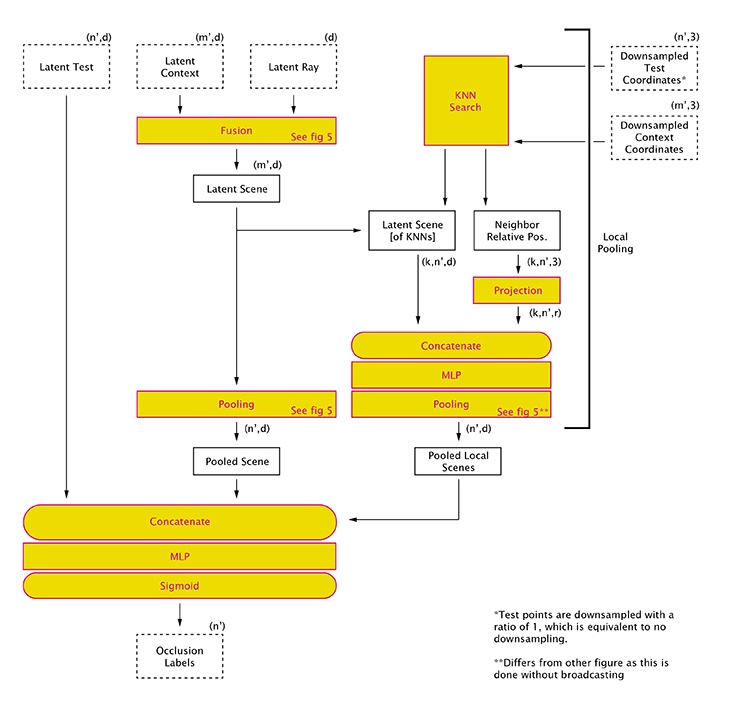

In [ ]:
class ShadingSurrogateMLPV2(nn.Module):
    """
      MLP-based surrogate for point-wise solar ray occlusion with global and local context.

      Extends the base ShadingSurrogateMLP by adding a local k-NN aggregation branch
      with relative position encoding. Context points are conditioned on solar
      direction, pooled globally to capture scene-level structure, and pooled locally
      around each test point to capture fine-grained geometric interactions. Global,
      local, and test-point features are concatenated and passed through an MLP to
      predict per-test-point occlusion logits.

      Inputs:
          context: (B, N, 3)   Context point cloud
          test:    (B, M, 3)   Test points
          solar:   (B, 3)      Solar direction vector

      Outputs:
          dict containing:
              logits: (B, M)   Binary occlusion logits
              prob:   (B, M)   Sigmoid probabilities
    """
    def __init__(self, context_encoder, test_encoder,pos_encoder,solar_encoder, embed_dim=128,hidden_dim=64, fusion_type = 'concat', knn=32):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.fusion_type = fusion_type
        self.context_encoder = context_encoder
        self.test_encoder = test_encoder
        self.pos_encoder = pos_encoder
        self.solar_encoder = solar_encoder
        self.k_neighbors = knn

        # relative local position (neighbor - test)
        self.rel_pos_dim = 32
        self.rel_pos_mapper = nn.Linear(3, self.rel_pos_dim)

        if fusion_type == 'concat':
            self.fusion = nn.Sequential(
                nn.Linear(2 * embed_dim, embed_dim),
                nn.LayerNorm(embed_dim),
                nn.ReLU(inplace=True)
            )
        elif fusion_type == 'gated':
            # Learn adaptive gate for solar information
            self.gate = nn.Sequential(
                nn.Linear(2 * embed_dim, embed_dim),
                nn.Sigmoid()
            )
            self.fusion = None
        else:  # 'add'
            self.fusion = None

        # --- THE FIX ---
        # 2. MLP to mix Neighbor Features + Relative Position BEFORE pooling
        # Input: (D features) + (rel_pos_dim)
        # Output: embed_dim (or whatever size you want the local feature to be)
        mixed_dim = embed_dim + self.rel_pos_dim
        self.local_mixer = nn.Sequential(
            nn.Linear(mixed_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(inplace=True)
        )

        # local branch: [mean, max] over K neighbors, each with (D)
        self.local_proj = nn.Linear(2 * embed_dim, embed_dim)

        self.global_proj = nn.Linear(2 * embed_dim, embed_dim)

        self.output_mlp = nn.Sequential(
            nn.Linear(3 * embed_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 1)  # Binary logit
        )

    def get_global_context(self, context_features):
        """
        Global pooling over the entire scene.
        """
        # context_features: (B, N, D)
        g_mean = context_features.mean(dim=1)            # (B, D)
        g_max = context_features.max(dim=1).values       # (B, D)
        g_combined = torch.cat([g_mean, g_max], dim=-1)  # (B, 2D)
        return self.global_proj(g_combined)              # (B, D)

    def fuse_solar_context(self, context_latent, solar_latent):
        """
        Fuse solar direction into context points.

        Args:
            context_latent: (B, N, D) - context point features
            solar_latent: (B, D) - solar direction embedding

        Returns:
            fused_context: (B, N, D) - solar-conditioned context
        """
        B, N, D = context_latent.shape

        # Broadcast solar to match context
        solar_expanded = solar_latent.unsqueeze(1).expand(B, N, D)

        if self.fusion_type == 'concat':
            fused = torch.cat([context_latent, solar_expanded], dim=-1)  # (B, N, 2D)
            fused_context = self.fusion(fused)  # (B, N, D)

        elif self.fusion_type == 'gated':
            concat = torch.cat([context_latent, solar_expanded], dim=-1)
            gate = self.gate(concat)  # (B, N, D) - learnable mixing weights
            fused_context = context_latent * (1 - gate) + solar_expanded * gate

        else:  # 'add'
            fused_context = context_latent + solar_expanded

        return fused_context

    def get_local_context(self, test_coords, context_coords, context_features):
        """
        k-NN pooling with Relative Position Injection.
        """
        B, M, _ = test_coords.shape
        _, N, D = context_features.shape
        K = min(self.k_neighbors, N)

        # 1. KNN Search
        # (B, M, N) - careful with memory here!
        dists = torch.cdist(test_coords, context_coords)
        _, knn_indices = torch.topk(dists, k=K, dim=-1, largest=False) # (B, M, K)

        # 2. Gather Features
        batch_idx = torch.arange(B, device=test_coords.device).view(B, 1, 1).expand(B, M, K)
        neighbor_features = context_features[batch_idx, knn_indices] # (B, M, K, D)
        neighbor_coords = context_coords[batch_idx, knn_indices]     # (B, M, K, 3)

        # 3. Compute Relative Position
        # test_coords is (B, M, 3) -> expand to (B, M, 1, 3) for broadcasting
        test_coords_expanded = test_coords.unsqueeze(2)
        rel_pos = neighbor_coords - test_coords_expanded # (B, M, K, 3)

        # 4. Encode Relative Position
        rel_pos_embed = self.rel_pos_mapper(rel_pos) # (B, M, K, rel_pos_dim)

        # 5. Concatenate
        # (B, M, K, D + rel_pos_dim)
        raw_concat = torch.cat([neighbor_features, rel_pos_embed], dim=-1)

        # 6. --- NEW STEP: Interaction MLP ---
        # This allows the network to learn "Feature X at Position Y matters"
        neighbor_embeddings = self.local_mixer(raw_concat) # (B, M, K, embed_dim)

        # 7. Pooling (Aggregate over K neighbors)
        # Now we pool the PROCESSED features
        local_mean = neighbor_embeddings.mean(dim=2)  # (B, M, embed_dim)
        local_max = neighbor_embeddings.max(dim=2).values # (B, M, embed_dim)

        # 8. Final projection
        local_combined = torch.cat([local_mean, local_max], dim=-1)
        return self.local_proj(local_combined)


    def forward(self, context, test, solar):
       """
        context: (B, N, 3)
        solar:   (B, 3)
        test:    (B, M, D3

        Returns: logits (B,) and prob (B,) if test_latent is (B, D).
        """

       context_inputs = self.context_encoder.transform(context)
       context_latent,context_coord = self.context_encoder(context_inputs)
       test_inputs  = self.test_encoder.transform(test)
       test_latent,test_coord = self.test_encoder(test_inputs)
       solar_latent = self.solar_encoder(solar)

       coord_latent = self.pos_encoder(context_coord)
       context_latent = context_latent + coord_latent

       test_coord_latent = self.pos_encoder(test_coord)
       test_latent = test_latent + test_coord_latent


       # Step 1: Fuse solar into context (Early Fusion)
       fused_context = self.fuse_solar_context(context_latent, solar_latent)

        # --- 1. Global Pooling Branch ---
       global_feat = self.get_global_context(fused_context)
        # Expand global to match number of test points M
       M = test_latent.shape[1]
       global_feat_expanded = global_feat.unsqueeze(1).expand(-1, M, -1) # (B, M, D)

        # --- 2. Local Pooling Branch (with Rel Pos) ---
       local_feat = self.get_local_context(test_coord, context_coord, fused_context) # (B, M, D)

       mlp_in = torch.cat([test_latent, local_feat, global_feat_expanded], dim=-1) # (B, M, 3D)

       logits = self.output_mlp(mlp_in).squeeze(-1)   # (B, M)
       prob = torch.sigmoid(logits)

       return {"logits": logits, "prob": prob}


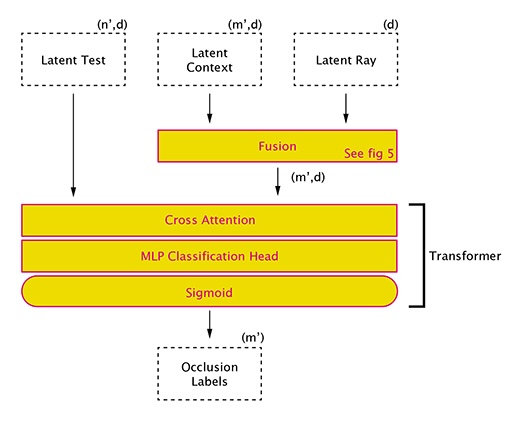

In [ ]:
class ShadingSurrogateTransformer(nn.Module):
    """
      Transformer-based surrogate for point-wise solar ray occlusion prediction.

      Encodes context points, test points, and solar direction into a shared latent
      space, fuses solar information into context features, and applies multi-head
      cross-attention from test points (queries) to context points (keys/values).
      The attention output is passed through a lightweight MLP head to predict
      per-test-point occlusion logits.

      Inputs:
          context: (B, N, 3)   Context point cloud
          test:    (B, M, 3)   Test points
          solar:   (B, 3)      Solar direction vector

      Outputs:
          dict containing:
              logits: (B, M)           Binary occlusion logits
              prob:   (B, M)           Sigmoid probabilities
              attn_weights: (B, M, N)  Cross-attention weights over context points
      """
    def __init__(self, context_encoder,test_encoder,pos_encoder,solar_encoder,embed_dim=256,hidden_dim=128, fusion_type = 'concat', num_heads = 4):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.fusion_type = fusion_type
        self.context_encoder = context_encoder
        self.test_encoder = test_encoder
        self.pos_encoder = pos_encoder
        self.solar_encoder = solar_encoder

        if fusion_type == 'concat':
            self.fusion = nn.Sequential(
                nn.Linear(2 * embed_dim, embed_dim),
                nn.LayerNorm(embed_dim),
                nn.ReLU(inplace=True)
            )
        elif fusion_type == 'gated':
            # Learn adaptive gate for solar information
            self.gate = nn.Sequential(
                nn.Linear(2 * embed_dim, embed_dim),
                nn.Sigmoid()
            )
            self.fusion = None
        else:  # 'add'
            self.fusion = None

        self.context_proj = nn.Linear(2 * embed_dim, embed_dim)

        self.mha = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True,  # so we can work with (B, N, D)
        )

        self.fc = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_dim, 1),  # binary logit
        )

    def fuse_solar_context(self, context_latent, solar_latent):
        """
        Fuse solar direction into context points.

        Args:
            context_latent: (B, N, D) - context point features
            solar_latent: (B, D) - solar direction embedding

        Returns:
            fused_context: (B, N, D) - solar-conditioned context
        """
        B, N, D = context_latent.shape

        # Broadcast solar to match context
        solar_expanded = solar_latent.unsqueeze(1).expand(B, N, D)

        if self.fusion_type == 'concat':
            fused = torch.cat([context_latent, solar_expanded], dim=-1)  # (B, N, 2D)
            fused_context = self.fusion(fused)  # (B, N, D)

        elif self.fusion_type == 'gated':
            concat = torch.cat([context_latent, solar_expanded], dim=-1)
            gate = self.gate(concat)  # (B, N, D) - learnable mixing weights
            fused_context = context_latent * (1 - gate) + solar_expanded * gate

        else:  # 'add'
            fused_context = context_latent + solar_expanded

        return fused_context


    def forward(self, context, test, solar):
       """
        context: (B, N, 3)
        solar:   (B, 3)
        test:    (B, M, D3

        Returns: logits (B,) and prob (B,) if test_latent is (B, D).
        """

       context_inputs = self.context_encoder.transform(context)
       context_latent,coord = self.context_encoder(context_inputs)
       test_inputs  = self.test_encoder.transform(test)
       test_latent,test_coord = self.test_encoder(test_inputs)
       solar_latent = self.solar_encoder(solar)

       coord_latent = self.pos_encoder(coord)
       context_latent = context_latent + coord_latent

       test_coord_latent = self.pos_encoder(test_coord)
       test_latent = test_latent + test_coord_latent

       _,M,_ = test_latent.shape
       # Step 1: Fuse solar into context (Early Fusion)
       fused_context = self.fuse_solar_context(context_latent, solar_latent)

       attn_output, attn_weights = self.mha(test_latent, fused_context, fused_context)

       logits = self.fc(attn_output).squeeze(-1)
       prob = torch.sigmoid(logits)

       return {
          "logits": logits,
          "prob": prob,
          "attn_weights": attn_weights  # over N fused context tokens
       }


# Training

## Training Helper

In [ ]:

def plot_metrics(history, save_path):
    """Plot training curves."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train')
    if history['val_loss']:
        axes[0].plot(epochs, history['val_loss'], 'r-', label='Val')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train')
    if history['val_acc']:
        axes[1].plot(epochs, history['val_acc'], 'r-', label='Val')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.close()

In [ ]:

def compute_metrics(logits, labels, mask=None):
    """
    Compute accuracy, precision, recall, F1 for binary classification.

    Args:
        logits: (B, M) - raw logits
        labels: (B, M) - ground truth binary labels
        mask: (B, M) - boolean mask indicating valid positions
    """
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    if mask is not None:
        # Only evaluate on valid positions
        preds = preds[mask]
        labels = labels[mask]
    else:
        preds = preds.reshape(-1)
        labels = labels.reshape(-1)

    # Basic metrics
    correct = (preds == labels).float()
    accuracy = correct.mean().item()

    # Precision, Recall, F1
    tp = ((preds == 1) & (labels == 1)).float().sum()
    fp = ((preds == 1) & (labels == 0)).float().sum()
    fn = ((preds == 0) & (labels == 1)).float().sum()

    precision = (tp / (tp + fp + 1e-8)).item()
    recall = (tp / (tp + fn + 1e-8)).item()
    f1 = (2 * precision * recall / (precision + recall + 1e-8))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:



def train_epoch(model, dataloader, optimizer, device, criterion):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    all_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for i, batch in enumerate(dataloader):
        # Get data - keep context as numpy arrays!
        context_list = batch['context_points']  # List of numpy arrays - DON'T convert to tensors
        test_points = batch['test_points']
        solar_vec = batch['solar_vec'].to(device)
        labels = batch['labels'].to(device)
        test_mask = batch['test_mask'].to(device)

        # Forward pass - model will handle transform internally
        optimizer.zero_grad()
        outputs = model(context_list, test_points, solar_vec)
        logits = outputs['logits']  # (B, M)

        # Compute loss only on valid positions
        loss = criterion(logits[test_mask], labels[test_mask])

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        metrics = compute_metrics(logits, labels, test_mask)
        for k, v in metrics.items():
            all_metrics[k].append(v)

        # Print every 5 batches
        if (i + 1) % 5 == 0:
            print(f"  Batch {i+1}/{len(dataloader)} | Loss: {loss.item():.4f} | Acc: {metrics['accuracy']:.4f}")

    # Average metrics
    avg_metrics = {k: np.mean(v) for k, v in all_metrics.items()}
    avg_metrics['loss'] = total_loss / len(dataloader)

    return avg_metrics


def validate(model, dataloader, device, criterion):
    """Validate the model."""
    model.eval()
    total_loss = 0
    all_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            # Get data - keep context as numpy arrays!
            context_list = batch['context_points']  # List of numpy arrays
            test_points = batch['test_points']
            solar_vec = batch['solar_vec'].to(device)
            labels = batch['labels'].to(device)
            test_mask = batch['test_mask'].to(device)

            # Forward pass
            outputs = model(context_list, test_points, solar_vec)
            logits = outputs['logits']

            # Compute loss
            loss = criterion(logits[test_mask], labels[test_mask])
            total_loss += loss.item()

            # Track metrics
            metrics = compute_metrics(logits, labels, test_mask)
            for k, v in metrics.items():
                all_metrics[k].append(v)

            # Print every 5 batches
            if (i + 1) % 5 == 0:
                print(f"  Batch {i+1}/{len(dataloader)} | Loss: {loss.item():.4f} | Acc: {metrics['accuracy']:.4f}")

    # Average metrics
    avg_metrics = {k: np.mean(v) for k, v in all_metrics.items()}
    avg_metrics['loss'] = total_loss / len(dataloader)

    return avg_metrics





In [ ]:

def train_model(
    model,
    train_files,  # Can be single file, list of files, or glob pattern
    model_type = 'mlp',
    use_fourier = True,
    val_files=None,
    num_epochs=50,
    batch_size=8,
    lr=1e-4,
    weight_decay=1e-5,
    checkpoint_dir='checkpoints',
    device='cuda',
    num_workers=2
):
    """
    Train the model with automatic monitoring.

    Args:
        model: The model to train
        train_files: Single .npz file path, list of paths, or glob pattern (e.g., 'data/train_*.npz')
        val_files: Validation files (same format as train_files)
        num_epochs: Number of epochs
        batch_size: Batch size
        lr: Learning rate
        weight_decay: L2 regularization
        checkpoint_dir: Where to save checkpoints
        device: 'cuda' or 'cpu'
        num_workers: DataLoader workers (use 0 for Colab if issues)

    Returns:
        history: Dict with training metrics
    """
    import glob
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_dir.mkdir(exist_ok=True, parents=True)

    # Handle glob patterns
    if isinstance(train_files, str) and ('*' in train_files or '?' in train_files):
        train_files = sorted(glob.glob(train_files))
        print(f"Found {len(train_files)} training files from pattern")

    if isinstance(val_files, str) and ('*' in val_files or '?' in val_files):
        val_files = sorted(glob.glob(val_files))
        print(f"Found {len(val_files)} validation files from pattern")

    # Create dataloaders using user's dataset classes
    if isinstance(train_files, str):
        train_dataset = ShadingFileDataset(train_files, training=True)
    else:
        train_dataset = MultiFileDataset(train_files, training=True)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=shading_collate_fn,
        num_workers=num_workers,
        pin_memory=True if device == 'cuda' else False
    )

    if val_files:
        if isinstance(val_files, str):
            val_dataset = ShadingFileDataset(val_files, training=False)
        else:
            val_dataset = MultiFileDataset(val_files, training=False)

        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=shading_collate_fn,
            num_workers=num_workers,
            pin_memory=True if device == 'cuda' else False
        )
    else:
        val_loader = None

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Save config
    config = {
        'model_type': model_type,
        'use_fourier': use_fourier,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
        'lr': lr,
        'weight_decay': weight_decay,
        'num_train': len(train_dataset),
        'num_val': len(val_dataset) if val_loader else 0
    }
    with open(checkpoint_dir / 'config.json', 'w') as f:
        json.dump(config, f, indent=2)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    best_val_loss = float('inf')

    print(f"\n{'='*80}")
    print(f"Training: {len(train_dataset)} samples | Val: {len(val_dataset) if val_loader else 0} samples")
    print(f"{'='*80}\n")

    # Training loop
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")

        # Train
        print("Training...")
        train_metrics = train_epoch(model, train_loader, optimizer, device, criterion)
        history['train_loss'].append(train_metrics['loss'])
        history['train_acc'].append(train_metrics['accuracy'])
        history['train_precision'].append(train_metrics['precision'])
        history['train_recall'].append(train_metrics['recall'])
        history['train_f1'].append(train_metrics['f1'])

        print(f"→ Train | Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['accuracy']:.4f} | "
              f"Prec: {train_metrics['precision']:.4f} | Rec: {train_metrics['recall']:.4f} | "
              f"F1: {train_metrics['f1']:.4f}")

        # Validate
        if val_loader:
            print("Validating...")
            val_metrics = validate(model, val_loader, device, criterion)
            history['val_loss'].append(val_metrics['loss'])
            history['val_acc'].append(val_metrics['accuracy'])
            history['val_precision'].append(val_metrics['precision'])
            history['val_recall'].append(val_metrics['recall'])
            history['val_f1'].append(val_metrics['f1'])
            scheduler.step(val_metrics['loss'])

            print(f"→ Val   | Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['accuracy']:.4f} | "
                  f"Prec: {val_metrics['precision']:.4f} | Rec: {val_metrics['recall']:.4f} | "
                  f"F1: {val_metrics['f1']:.4f}")

            # Save best model
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_metrics['loss'],
                    'val_acc': val_metrics['accuracy']
                }, checkpoint_dir / 'best_model.pt')
                print(f"✓ Saved best model (val_loss: {val_metrics['loss']:.4f})")

        # Plot every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_metrics(history, checkpoint_dir / 'training_curves.png')
            print(f"✓ Updated training curves")

    # Final save
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_dir / 'final_model.pt')

    # Save history
    with open(checkpoint_dir / 'history.json', 'w') as f:
        json.dump(history, f, indent=2)

    # Final plot
    plot_metrics(history, checkpoint_dir / 'training_curves.png')

    print(f"\n{'='*80}")
    print(f"Training complete! Best val loss: {best_val_loss:.4f}")
    print(f"Saved to: {checkpoint_dir}/")
    print(f"{'='*80}\n")

    return history



## Actual Training

In [ ]:
train_folder = "/content/drive/MyDrive/DeepLearningProject/data/train/*.npz"
val_folder = "/content/drive/MyDrive/DeepLearningProject/data/val/*.npz"
checkpoint_dir = "/content/drive/MyDrive/DeepLearningProject/checkpoints/new_check point"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Stage 1
MLP vs Transformer (w/ w/o Fourier)

In [ ]:
#RandLA-Net encoder set up for experiment 1
original_model = ml3d.models.RandLANet(
    num_neighbors=32,
    num_layers=3,
    num_points = 4096*11,
    num_classes =2,
    sub_sampling_ratio=[2,2,2],
    in_channels = 3,
    dim_features = 8,
    dim_output = [16,64,128]
)

original_model_2_3layer = ml3d.models.RandLANet(
    num_neighbors=32,
    num_layers=3,
    num_points = 4096*11,
    num_classes = 2,
    sub_sampling_ratio=[1,1,1],
    in_channels = 3,
    dim_features = 8,
    dim_output = [16,64,128]
)

In [ ]:
# Encoders with Fourier
encoder = RandLAEncoder(original_model, device=device).to(device)
encoder2 = RandLAEncoder(original_model_2_3layer, device=device).to(device)
test_encoder = PtPositionEncoder(device=device,output_dim=256, num_frequencies=10).to(device)
solar_encoder = Solar_Embed(device=device,output_dim=256,num_frequencies=4).to(device)

In [ ]:
# MLP w/ Fourier
model_mlp_withfourier = ShadingSurrogateMLP(
    context_encoder=encoder,
    test_encoder=encoder2,
    pos_encoder=test_encoder,
    solar_encoder=solar_encoder,
    embed_dim=256,
    hidden_dim=128,
    fusion_type='concat'  # or 'concat' or 'add'
).to(device)

In [ ]:
# Transformer w/ Fourier
model_transformer_withfourier = ShadingSurrogateTransformer(
    context_encoder=encoder,
    test_encoder=encoder2,
    pos_encoder=test_encoder,
    solar_encoder=solar_encoder,
    embed_dim=256,
    hidden_dim=128,
    fusion_type='concat'  # or 'concat' or 'add'
).to(device)

In [ ]:
# Encoders w/o Fourier
encoder = RandLAEncoder(original_model, device=device).to(device)
encoder2 = RandLAEncoder(original_model_2_3layer, device=device).to(device)
test_encoder = PtPositionEncoder(device=device,output_dim=256,use_fourier=False).to(device)
solar_encoder = Solar_Embed(device=device,output_dim=256,use_fourier=False).to(device)

In [ ]:
# MLP w/o Fourier
model_mlp_no = ShadingSurrogateMLP(
    context_encoder=encoder,
    test_encoder=encoder2,
    pos_encoder=test_encoder,
    solar_encoder=solar_encoder,
    embed_dim=256,
    hidden_dim=128,
    fusion_type='concat'  # or 'concat' or 'add'
).to(device)

In [ ]:
# Transformer w/o Fourier
model_transformer_no = ShadingSurrogateTransformer(
    context_encoder=encoder,
    test_encoder=encoder2,
    pos_encoder=test_encoder,
    solar_encoder=solar_encoder,
    embed_dim=256,
    hidden_dim=128,
    fusion_type='concat'  # or 'concat' or 'add'
).to(device)

### Stage 2 Downsampling Ratio

MLP and Transformer w/ Fourier
Tested with 8x vs 4x context point downsampling

In [ ]:
# Shallower encoders

original_model_shallow = ml3d.models.RandLANet(
    num_neighbors=32,
    num_layers= 2,
    num_points = 4096*11,
    num_classes =2,
    sub_sampling_ratio= [2,2],
    in_channels = 3,
    dim_features = 8,
    dim_output = [32,64]
)

original_model_shallow_2 = ml3d.models.RandLANet(
    num_neighbors=32,
    num_layers=2,
    num_points = 4096*11,
    num_classes = 2,
    sub_sampling_ratio=[1,1],
    in_channels = 3,
    dim_features = 8,
    dim_output = [32,64]
)


In [ ]:
# New encoders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = RandLAEncoder(original_model_shallow, device=device).to(device)
encoder2 = RandLAEncoder(original_model_shallow_2, device=device).to(device)
test_encoder = PtPositionEncoder(device=device,output_dim=128,num_frequencies=10).to(device)
solar_encoder = Solar_Embed(device=device,output_dim=128,num_frequencies=4).to(device)

In [ ]:
# New classification head

model_mlp_config2 = ShadingSurrogateMLP(
    context_encoder=encoder,
    test_encoder=encoder2,
    pos_encoder=test_encoder,
    solar_encoder=solar_encoder,
    embed_dim=128,
    hidden_dim=64,
    fusion_type='concat'  # or 'concat' or 'add'
).to(device)

model_transformer_config2 = ShadingSurrogateTransformer(
    context_encoder=encoder,
    test_encoder=encoder2,
    pos_encoder=test_encoder,
    solar_encoder=solar_encoder,
    embed_dim=128,
    hidden_dim=64,
    fusion_type='concat'  # or 'concat' or 'add'
).to(device)

Also, we tested further aggresively downsample for MLP but worked poorly

In [ ]:
# RandLA Set Up
original_model_shallower = ml3d.models.RandLANet(
    num_neighbors=64,
    num_layers= 2,
    num_points = 4096*11,
    num_classes =2,
    sub_sampling_ratio= [2,1],
    in_channels = 3,
    dim_features = 8,
    dim_output = [16,32]
)

original_model_test_shallower = ml3d.models.RandLANet(
    num_neighbors=64,
    num_layers=2,
    num_points = 4096*11,
    num_classes = 2,
    sub_sampling_ratio=[1,1],
    in_channels = 3,
    dim_features = 8,
    dim_output = [16,32]
)

# Encoders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = RandLAEncoder(original_model_shallower, device=device).to(device)
encoder2 = RandLAEncoder(original_model_test_shallower, device=device).to(device)
test_encoder = PtPositionEncoder(device=device,output_dim=64,num_frequencies=4).to(device)
solar_encoder = Solar_Embed(device=device,output_dim=64,num_frequencies=2).to(device)

# Classifier
model_mlp_config3 = ShadingSurrogateMLP(
    context_encoder=encoder,
    test_encoder=encoder2,
    pos_encoder=test_encoder,
    solar_encoder=solar_encoder,
    embed_dim=64,
    hidden_dim=32,
    fusion_type='concat'  # or 'concat' or 'add'
).to(device)

### Stage 3 Local Pooling

At stage three we train the second version of MLP with local pooling.

In [ ]:
# Shallower encoders

original_model_shallow = ml3d.models.RandLANet(
    num_neighbors=32,
    num_layers= 2,
    num_points = 4096*11,
    num_classes =2,
    sub_sampling_ratio= [2,2],
    in_channels = 3,
    dim_features = 8,
    dim_output = [32,64]
)

original_model_shallow_2 = ml3d.models.RandLANet(
    num_neighbors=32,
    num_layers=2,
    num_points = 4096*11,
    num_classes = 2,
    sub_sampling_ratio=[1,1],
    in_channels = 3,
    dim_features = 8,
    dim_output = [32,64]
)


In [ ]:
#encoders
encoder = RandLAEncoder(original_model_shallow, device=device).to(device)
encoder2 = RandLAEncoder(original_model_shallow_2, device=device).to(device)
test_encoder = PtPositionEncoder(device=device, output_dim=128,num_frequencies=10).to(device)
solar_encoder = Solar_Embed(device=device, output_dim=128, num_frequencies=4).to(device)

# Classifier
model_mlpv2 = ShadingSurrogateMLPV2(
    context_encoder=encoder,
    test_encoder=encoder2,
    pos_encoder=test_encoder,
    solar_encoder=solar_encoder,
    embed_dim=128,
    hidden_dim=64,
    fusion_type='concat'  # or 'concat' or 'add'
    knn=32
).to(device)


### Training

In [ ]:
import gc
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def clear_gpu_memory():
    """Force clear GPU memory"""
    # Clear PyTorch cache
    torch.cuda.empty_cache()

    # Force garbage collection
    gc.collect()

    # Optional: Reset peak memory stats
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.reset_accumulated_memory_stats()

# Use before training
clear_gpu_memory()

# Check current memory usage
print(f"Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
print(f"Reserved: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")

In [ ]:
history = train_model(
    model=model_mlp,
    model_type = "mlp",
    use_fourier = True,
    train_files=train_folder,
    val_files=val_folder,  # optional
    num_epochs=20,
    batch_size= 8,
    lr=1e-4,
    checkpoint_dir=checkpoint_dir,
    device=device
)


Found 2 training files from pattern
Found 1 validation files from pattern
Loaded 2 files with 1377 total samples
Loaded 1 files with 393 total samples

Training: 1377 samples | Val: 393 samples


Epoch 1/20
Training...


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  Batch 5/173 | Loss: 0.6798 | Acc: 0.6057
  Batch 10/173 | Loss: 0.6670 | Acc: 0.6774
  Batch 15/173 | Loss: 0.6992 | Acc: 0.4919
  Batch 20/173 | Loss: 0.6766 | Acc: 0.6143
  Batch 25/173 | Loss: 0.6797 | Acc: 0.5944
  Batch 30/173 | Loss: 0.6648 | Acc: 0.6716
  Batch 35/173 | Loss: 0.6541 | Acc: 0.7146
  Batch 40/173 | Loss: 0.6921 | Acc: 0.5354
  Batch 45/173 | Loss: 0.6842 | Acc: 0.5657
  Batch 50/173 | Loss: 0.6885 | Acc: 0.5524
  Batch 55/173 | Loss: 0.6713 | Acc: 0.6108
  Batch 60/173 | Loss: 0.6805 | Acc: 0.5780
  Batch 65/173 | Loss: 0.6855 | Acc: 0.5629
  Batch 70/173 | Loss: 0.6520 | Acc: 0.6636
  Batch 75/173 | Loss: 0.6059 | Acc: 0.7881
  Batch 80/173 | Loss: 0.6028 | Acc: 0.7723
  Batch 85/173 | Loss: 0.6903 | Acc: 0.5553
  Batch 90/173 | Loss: 0.6238 | Acc: 0.6959
  Batch 95/173 | Loss: 0.6778 | Acc: 0.5897
  Batch 100/173 | Loss: 0.7005 | Acc: 0.5419
  Batch 105/173 | Loss: 0.6675 | Acc: 0.6019
  Batch 110/173 | Loss: 0.6631 | Acc: 0.5931
  Batch 115/173 | Loss: 0.6099

# Testing

## Testing Helper

In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def load_trained_model(checkpoint_path, model, device='cuda'):
    """
    Load a trained model from checkpoint.

    Args:
        checkpoint_path: Path to .pt checkpoint file
        model: Initialized model instance
        device: 'cuda' or 'cpu'

    Returns:
        model: Loaded model ready for inference
        checkpoint_info: Dictionary with training info
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode

    # Get training info
    info = {
        'epoch': checkpoint.get('epoch', 'unknown'),
        'val_loss': checkpoint.get('val_loss', 'N/A'),
        'val_acc': checkpoint.get('val_acc', 'N/A'),
    }

    print(f"Loaded model from epoch {info['epoch']}")
    if info['val_loss'] != 'N/A':
        print(f"  Val Loss: {info['val_loss']:.4f}")
        print(f"  Val Acc:  {info['val_acc']:.4f}")

    return model, info





# ============================================================================
# Single Sample Inference
# ============================================================================

def predict_single_sample(model, context, test_points, solar_vec, device='cuda'):
    """
    Run inference on a single sample.

    Args:
        model: Trained model
        context: (N, 3) numpy array - context point cloud
        test_points: (M, 3) numpy array - test points
        solar_vec: (3,) numpy array - solar direction
        device: 'cuda' or 'cpu'

    Returns:
        predictions: (M,) binary predictions (0=shadow, 1=sunlit)
        probabilities: (M,) prediction probabilities
    """
    model.eval()

    with torch.no_grad():
        # Prepare inputs - add batch dimension
        context_list = [context]  # List with single array
        test_list = [test_points]
        #test_batch = torch.from_numpy(test_points).float().unsqueeze(0).to(device)  # (1, M, 3)
        solar_batch = torch.from_numpy(solar_vec).float().unsqueeze(0).to(device)   # (1, 3)

        # Forward pass
        outputs = model(context_list, test_list, solar_batch)

        # Get predictions - use force=True for PyTorch 2.x
        probs = outputs['prob'][0].detach().cpu().numpy(force=True)  # (M,)
        preds = (probs > 0.5).astype(np.float32)

    return preds, probs


# ============================================================================
# Visualization
# ============================================================================

def visualize_predictions(test_points, context, labels, predictions, probabilities, save_path=None):
    """
    Visualize prediction results.

    Args:
        test_points: (M, 3) test point coordinates (numpy array or tensor)
        labels: (M,) ground truth labels (numpy array or tensor)
        predictions: (M,) predicted labels (numpy array or tensor)
        probabilities: (M,) prediction probabilities (numpy array or tensor)
        save_path: Optional path to save the figure
    """
    # Ensure all inputs are numpy arrays for matplotlib compatibility
    if torch.is_tensor(test_points):
        test_points = test_points.detach().cpu().numpy()
    if torch.is_tensor(labels):
        labels = labels.detach().cpu().numpy()
    if torch.is_tensor(predictions):
        predictions = predictions.detach().cpu().numpy()
    if torch.is_tensor(probabilities):
        probabilities = probabilities.detach().cpu().numpy()

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # 1. Ground Truth
    ax = axes[0, 0]
    scatter = ax.scatter(test_points[:, 0], test_points[:, 1],
                        c=labels, cmap='RdYlGn', s=10, alpha=0.6, zorder =10)
    scatter2 = ax.scatter(context[:, 0], context[:, 1],
                        c=context[:,2], cmap='Greys', s=10, alpha=0.6)
    ax.set_title('Ground Truth (Red=Shadow, Green=Sunlit)', fontsize=12)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.colorbar(scatter, ax=ax)



    # 2. Predictions
    ax = axes[0, 1]
    scatter = ax.scatter(test_points[:, 0], test_points[:, 1],
                        c=predictions, cmap='RdYlGn', s=10, alpha=0.6, vmin=0,vmax=1,zorder=4)
    scatter2 = ax.scatter(context[:, 0], context[:, 1],
                        c=context[:,2], cmap='Greys', s=10, alpha=0.6)
    ax.set_title('Predictions', fontsize=12)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.colorbar(scatter, ax=ax)

    # 3. Prediction Confidence
    ax = axes[1, 0]
    scatter = ax.scatter(test_points[:, 0], test_points[:, 1],
                        c=probabilities, cmap='viridis', s=10, alpha=0.6, vmin=0, vmax=1)
    ax.set_title('Prediction Confidence (Probability of Sunlit)', fontsize=12)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.colorbar(scatter, ax=ax, label='Probability')

    # 4. Errors
    ax = axes[1, 1]
    errors = (predictions != labels).astype(float)
    scatter = ax.scatter(test_points[:, 0], test_points[:, 1],
                        c=errors, cmap='Reds', s=10, alpha=0.6)
    ax.set_title(f'Errors (Red = Wrong, {int(errors.sum())}/{len(errors)} incorrect)', fontsize=12)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.colorbar(scatter, ax=ax)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Visualization saved to {save_path}")

    plt.show()


def plot_confusion_matrix(labels, predictions, save_path=None):
    """Plot confusion matrix."""
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    cm = confusion_matrix(labels, predictions)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=['Shadow', 'Sunlit'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Confusion matrix saved to {save_path}")

    plt.show()




In [ ]:
def test_model(model, test_files, batch_size=8, device='cuda', num_workers=0):
    """
    Run model on test dataset and compute metrics + inference efficiency.

    Args:
        model: Trained model (already initialized)
        test_files: Path to test .npz file(s) or glob pattern
        batch_size: Batch size for testing
        device: 'cuda' or 'cpu' or torch.device
        num_workers: Number of dataloader workers

    Returns:
        results: Dictionary with metrics, predictions, and efficiency stats:
                 - loss, accuracy, precision, recall, f1 (all dataset-level)
                 - predictions, labels, probabilities
                 - total_time_s, time_per_sample_s, samples_per_second
                 - peak_mem_mb (if CUDA, else None)
    """
    device = torch.device(device)

    # Handle glob patterns
    if isinstance(test_files, str) and ('*' in test_files or '?' in test_files):
        test_files = sorted(glob.glob(test_files))
        print(f"Found {len(test_files)} test files")

    # Create dataset
    if isinstance(test_files, str):
        test_dataset = ShadingFileDataset(test_files, training=False)
    else:
        test_dataset = MultiFileDataset(test_files, training=False)

    # Create dataloader
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,  # Don't shuffle test data
        collate_fn=shading_collate_fn,
        num_workers=num_workers,
        pin_memory=True if device.type == 'cuda' else False
    )

    num_samples = len(test_dataset)
    print(f"\nTesting on {num_samples} samples...")

    model.eval()
    model.to(device)

    all_predictions = []
    all_labels = []
    all_probs = []
    total_loss = 0.0

    criterion = torch.nn.BCEWithLogitsLoss()

    # ---- Reset CUDA memory stats (if applicable) ----
    peak_mem_mb = None
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)

    # ---- Timed inference loop ----
    start_time = time.perf_counter()

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            # Get data
            context_list = batch['context_points']
            test_points = batch['test_points']
            solar_vec = batch['solar_vec'].to(device)
            labels = batch['labels'].to(device)
            test_mask = batch['test_mask'].to(device)

            # Forward pass
            outputs = model(context_list, test_points, solar_vec)
            logits = outputs['logits']
            probs = outputs['prob']

            # Compute loss (batch-level)
            loss = criterion(logits[test_mask], labels[test_mask])
            total_loss += loss.item()

            # Store predictions and labels (masked)
            preds = (probs > 0.5).float()
            all_predictions.append(
                preds[test_mask].detach().cpu().numpy(force=True)
            )
            all_labels.append(
                labels[test_mask].detach().cpu().numpy(force=True)
            )
            all_probs.append(
                probs[test_mask].detach().cpu().numpy(force=True)
            )

            # Optional: batch-level debug print (still okay)
            if (i + 1) % 10 == 0:
                # quick batch accuracy for logging only
                batch_preds = preds[test_mask]
                batch_labels = labels[test_mask]
                batch_acc = (batch_preds == batch_labels).float().mean().item()
                print(
                    f"  Batch {i+1}/{len(test_loader)} | "
                    f"Loss: {loss.item():.4f} | Acc: {batch_acc:.4f}"
                )

    end_time = time.perf_counter()
    total_time_s = end_time - start_time
    time_per_sample_s = total_time_s / num_samples if num_samples > 0 else float('nan')
    samples_per_second = num_samples / total_time_s if total_time_s > 0 else float('nan')

    # Peak memory (if CUDA)
    if device.type == 'cuda':
        peak_mem_bytes = torch.cuda.max_memory_allocated(device)
        peak_mem_mb = peak_mem_bytes / (1024 ** 2)

    # Aggregate arrays
    all_predictions = np.concatenate(all_predictions).astype(np.float32)
    all_labels = np.concatenate(all_labels).astype(np.float32)
    all_probs = np.concatenate(all_probs).astype(np.float32)

    # ---- Dataset-level metrics (micro) ----
    # Flatten
    y_pred = all_predictions.reshape(-1)
    y_true = all_labels.reshape(-1)

    # Accuracy
    accuracy = (y_pred == y_true).mean()

    # TP, FP, FN
    tp = np.logical_and(y_pred == 1.0, y_true == 1.0).sum()
    fp = np.logical_and(y_pred == 1.0, y_true == 0.0).sum()
    fn = np.logical_and(y_pred == 0.0, y_true == 1.0).sum()

    # Precision, Recall, F1 (with safe guards)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (
        2.0 * precision * recall / (precision + recall)
        if (precision + recall) > 0
        else 0.0
    )

    results = {
        'loss': total_loss / len(test_loader),
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probs,
        # efficiency stats
        'total_time_s': total_time_s,
        'time_per_sample_s': time_per_sample_s,
        'samples_per_second': samples_per_second,
        'peak_mem_mb': peak_mem_mb,
        'num_samples': num_samples,
    }

    # Print summary
    print("\n" + "="*60)
    print("TEST RESULTS (dataset-level)")
    print("="*60)
    print(f"Loss:      {results['loss']:.4f}")
    print(f"Accuracy:  {results['accuracy']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall:    {results['recall']:.4f}")
    print(f"F1 Score:  {results['f1']:.4f}")
    print("-" * 60)
    print(f"Total time:        {results['total_time_s']:.3f} s")
    print(f"Time per sample:   {results['time_per_sample_s']*1000:.3f} ms")
    print(f"Samples / second:  {results['samples_per_second']:.2f}")
    if results['peak_mem_mb'] is not None:
        print(f"Peak GPU memory:   {results['peak_mem_mb']:.2f} MB")
    else:
        print("Peak GPU memory:   N/A (CPU device)")
    print("="*60)

    return results


## Actual Testing

In [ ]:
#model, info = load_trained_model('/content/drive/MyDrive/jsLocalPath/DeepLearningProject/checkpoints/mlp_testencoder_1130/best_model.pt', model_mlp_withfourier, device)

# model, info = load_trained_model('/content/drive/MyDrive/jsLocalPath/DeepLearningProject/checkpoints/mlp_testencoder_nofourier_1130/best_model.pt', model_mlp_no, device)

# model, info = load_trained_model('/content/drive/MyDrive/jsLocalPath/DeepLearningProject/checkpoints/transformer_testencoder_1129/best_model.pt', model_transformer_withfourier, device)

# model, info = load_trained_model('/content/drive/MyDrive/jsLocalPath/DeepLearningProject/checkpoints/transformer_testencoder_nofourier_1130/best_model.pt', model_transformer_no, device)

Loaded model from epoch 20
  Val Loss: 0.5217
  Val Acc:  0.7389


In [ ]:
results = test_model(
        model=model,
        test_files='/content/drive/MyDrive/jsLocalPath/DeepLearningProject/data/test/*.npz',  # Glob pattern
        batch_size=8,
        device=device,
        num_workers=0
    )

Found 1 test files
Loaded 1 files with 198 total samples

Testing on 198 samples...
  Batch 10/25 | Loss: 0.5870 | Acc: 0.6543
  Batch 20/25 | Loss: 0.4987 | Acc: 0.7382

TEST RESULTS (dataset-level)
Loss:      0.5108
Accuracy:  0.7462
Precision: 0.7737
Recall:    0.8672
F1 Score:  0.8178
------------------------------------------------------------
Total time:        45.322 s
Time per sample:   228.898 ms
Samples / second:  4.37
Peak GPU memory:   8076.28 MB


In [ ]:
#modeld4, info = load_trained_model('/content/drive/MyDrive/jsLocalPath/DeepLearningProject/checkpoints/mlp_4downsample_1201/best_model.pt', model_mlp_config2, device)
# model, info = load_trained_model('/content/drive/MyDrive/jsLocalPath/DeepLearningProject/checkpoints/transformer_4downsample_1208/best_model.pt', model_transformer_config2, device)
# model, info = load_trained_model('/content/drive/MyDrive/jsLocalPath/DeepLearningProject/checkpoints/mlp_2downsample_1208/best_model.pt', model_mlp_config3, device)

Loaded model from epoch 19
  Val Loss: 0.5169
  Val Acc:  0.7415


In [ ]:
#modelv2, info = load_trained_model('/content/drive/MyDrive/jsLocalPath/DeepLearningProject/checkpoints/mlpv25_augmented_4downsample_1209/best_model.pt', model_mlpv2, device)


Loaded model from epoch 20
  Val Loss: 0.3822
  Val Acc:  0.8280
params: 266337


## Visualization

In [ ]:

VISIBLE_PINK   = np.array([253/255, 170/255, 170/255])  # #FDAAAA
OCCLUDED_GREEN = np.array([91/255, 135/255, 93/255])   # #59AC77


def _binary_to_colors(labels):
    """
    labels: (M,) with 0 = occluded, 1 = visible
    returns: (M, 3) rgb in [0,1]
    """
    labels = labels.astype(int)
    colors = np.zeros((labels.shape[0], 3), dtype=float)
    colors[labels == 0] = OCCLUDED_GREEN   # occluded
    colors[labels == 1] = VISIBLE_PINK     # visible
    return colors
def visualize_samples_from_indices(
    model,
    data,
    indices,
    device="cuda",
    save_path=None,
):
    """
    Clean visualization with:
    - Square plots
    - No axis frames
    - Minimal spacing
    - Consistent layout
    - One global colorbar + title
    """

    indices = list(indices)
    n_rows = len(indices)
    assert n_rows > 0, "No indices provided."

    # --- Square figures: width = height for each subplot ---
    fig, axes = plt.subplots(
        n_rows, 4,
        figsize=(4 * 3.2, n_rows * 3.2),  # each graph ~ square
        squeeze=False
    )


    model.eval()
    last_scatter = None

    for row, ind in enumerate(indices):
        # -----------------------------
        # Load sample
        # -----------------------------
        context = data["context_list"][ind].astype(np.float32).reshape(-1, 3)
        test_pts = data["test_list"][ind].astype(np.float32).reshape(-1, 3)
        solar_vec = data["solar_list"][ind].astype(np.float32)
        labels = data["label_list"][ind].astype(np.float32).reshape(-1)

        # -----------------------------
        # Predict
        # -----------------------------
        preds, probs = predict_single_sample(
            model, context, test_pts, solar_vec, device=device
        )
        preds = preds.astype(float)
        probs = probs.astype(float)

        # -----------------------------
        # Build error map
        # -----------------------------
        err = (preds != labels).astype(float)
        err_colors = np.full((len(err), 3), 0.8)
        err_colors[err == 1] = [0.9, 0.1, 0.1]

        # -----------------------------
        # Row label
        # -----------------------------
        axes[row, 0].set_ylabel(
            f"Sample {ind}",
            fontsize=11,
            rotation=90,
            labelpad=8,
            fontweight="bold"
        )

        # =====================================================
        # Helper: clean scatter draw
        # =====================================================
        def draw(ax, colors):
            ax.scatter(test_pts[:, 0], test_pts[:, 1],
                       c=colors, s=6, alpha=0.9, zorder=5)
            ax.scatter(context[:, 0], context[:, 1],
                       c=context[:, 2], cmap="Greys", s=3, alpha=0.3)

            # Square aspect ratio & no frame
            ax.set_aspect("equal", adjustable="box")
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)

        # -----------------------------
        # Column 1 — Ground Truth
        # -----------------------------
        ax = axes[row, 0]
        draw(ax, _binary_to_colors(labels))
        if row == 0:
            ax.set_title("Ground Truth", fontsize=12, pad=6)

        # -----------------------------
        # Column 2 — Predictions
        # -----------------------------
        ax = axes[row, 1]
        draw(ax, _binary_to_colors(preds))
        if row == 0:
            ax.set_title("Prediction", fontsize=12, pad=6)

        # -----------------------------
        # Column 3 — Error
        # -----------------------------
        ax = axes[row, 2]
        draw(ax, err_colors)
        if row == 0:
            ax.set_title("Error", fontsize=12, pad=6)

        # -----------------------------
        # Column 4 — Probability
        # -----------------------------
        ax = axes[row, 3]
        draw(ax, probs)
        last_scatter = ax.scatter(
            test_pts[:, 0], test_pts[:, 1],
            c=probs, cmap="viridis", s=6, alpha=0.9,
            vmin=0, vmax=1
        )
        if row == 0:
            ax.set_title("Probability", fontsize=12, pad=6)

    # ============================================================
    # Shared bottom colorbar
    # ============================================================
    cbar_ax = fig.add_axes([0.6, 0.08, 0.28, 0.03])
    cbar = fig.colorbar(last_scatter, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("P(visible)", fontsize=10)

    # -----------------------------
    # One-line icon legend (pink / green), aligned with colorbar
    # -----------------------------
    legend_ax = fig.add_axes([0.3, 0.08, 0.3, 0.02])  # same left/width as cbar, just a bit lower
    legend_ax.axis("off")

    # Pink square (visible)
    legend_ax.text(
        0.35, 0.5, u"\u25A0",  # ■
        color="#FDAAAA",
        ha="right", va="center",
        fontsize=10
    )
    legend_ax.text(
        0.36, 0.5, "Visible",
        ha="left", va="center",
        fontsize=9
    )

    # Green square (occluded)
    legend_ax.text(
        0.65, 0.5, u"\u25A0",  # ■
        color="#5b875d",
        ha="right", va="center",
        fontsize=10
    )
    legend_ax.text(
        0.66, 0.5, "Occluded",
        ha="left", va="center",
        fontsize=9
    )

    plt.subplots_adjust(
        wspace=0.05,   # reduce horizontal space
        hspace=0.10    # reduce vertical space
    )

    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Visualization saved to {save_path}")

    plt.show()



/tmp/ipython-input-2102647429.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.06, 1, 0.95])


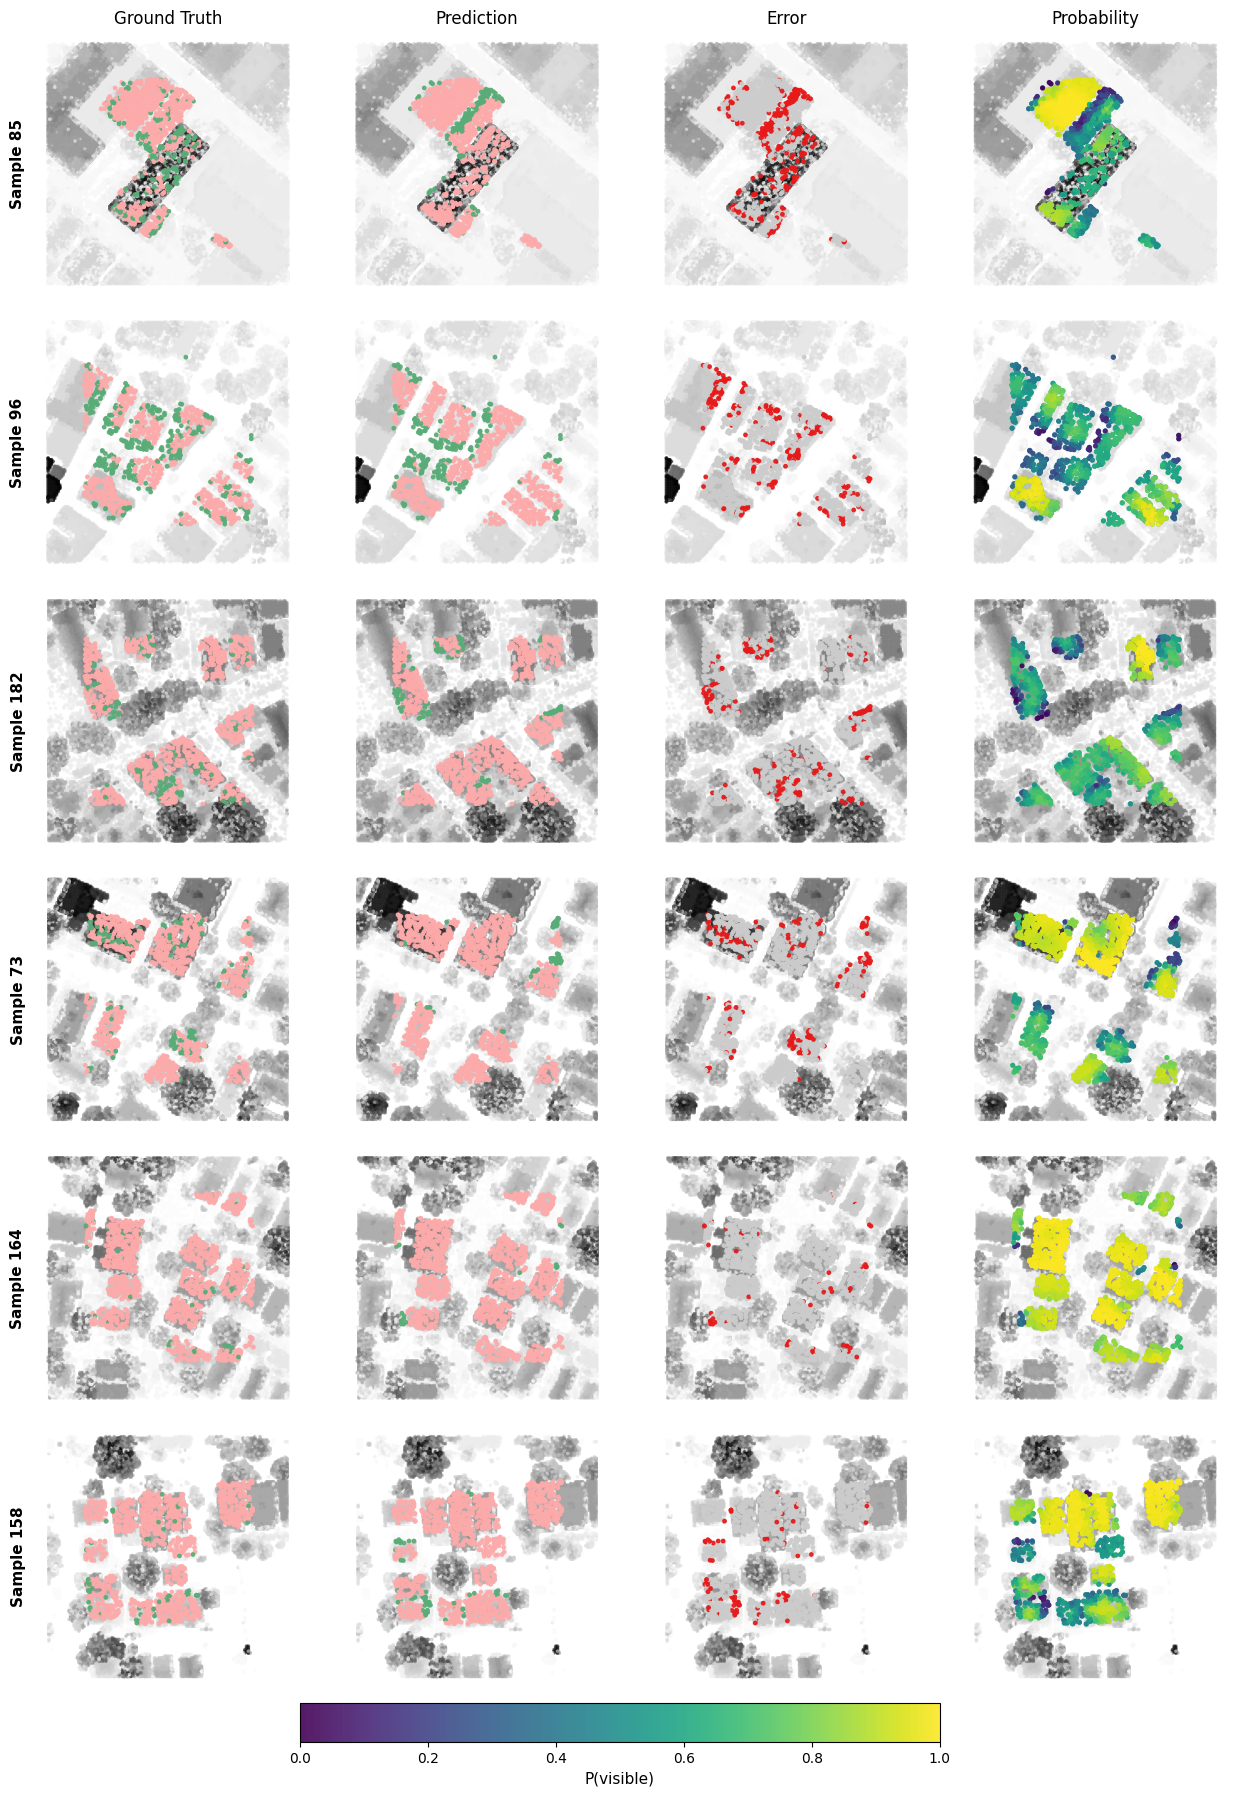

In [ ]:
data = np.load('/content/drive/MyDrive/jsLocalPath/DeepLearningProject/data/test/test_chunk_000.npz', allow_pickle=True)


Visualization saved to /content/drive/MyDrive/jsLocalPath/DeepLearningProject/graph/samples_grid_basic_blog.png


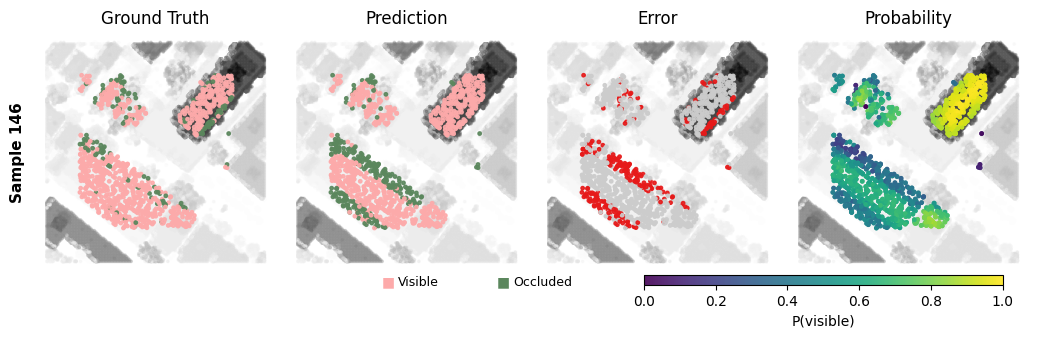

In [ ]:
# num_samples = 6
# ind = np.random.choice(len(data['context_list']), size=num_samples, replace=False)
ind = [146]
visualize_samples_from_indices(
    model,
    data,
    indices=ind,
    device='cuda',
    save_path="/content/drive/MyDrive/jsLocalPath/DeepLearningProject/graph/samples_grid_basic_blog.png"
)

Visualization saved to /content/drive/MyDrive/jsLocalPath/DeepLearningProject/graph/samples_grid_4downsample_blog.png


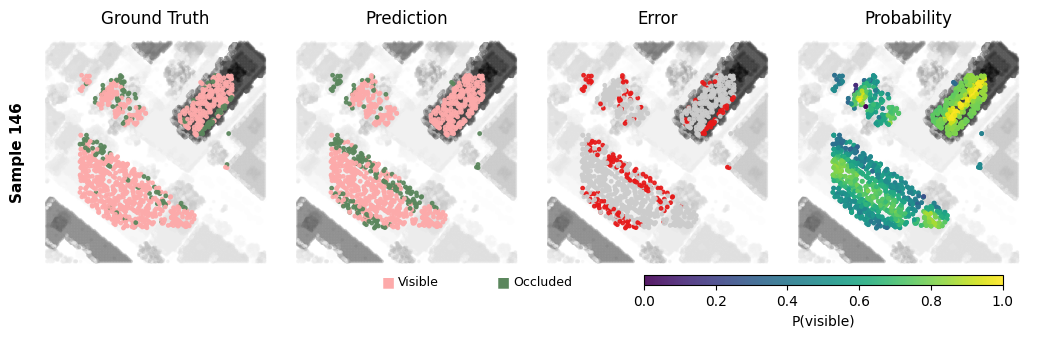

In [ ]:

visualize_samples_from_indices(
    modeld4,
    data,
    indices=ind,
    device='cuda',
    save_path="/content/drive/MyDrive/jsLocalPath/DeepLearningProject/graph/samples_grid_4downsample_blog.png"
)

Visualization saved to /content/drive/MyDrive/jsLocalPath/DeepLearningProject/samples_grid_localPooling_blog.png


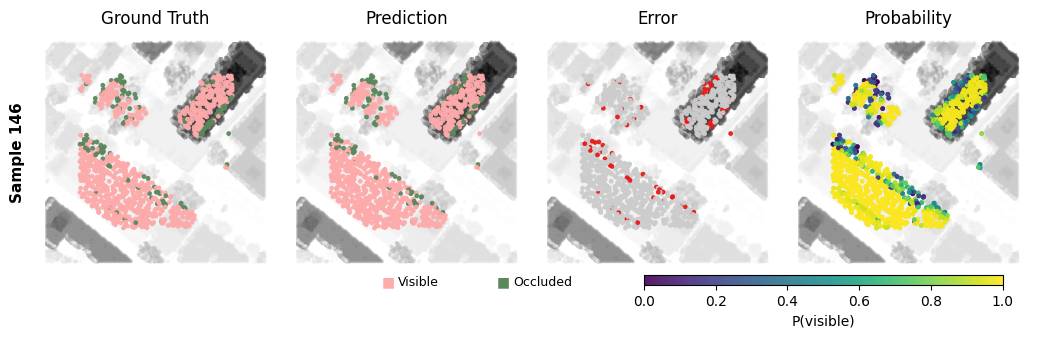

In [ ]:

#indices = [10]  # any subset / order you like

visualize_samples_from_indices(
    modelv2,
    data,
    indices=ind,
    device='cuda',
    save_path="/content/drive/MyDrive/jsLocalPath/DeepLearningProject/samples_grid_localPooling_blog.png"
)